# Scatter plot

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [27]:
import geopandas as gpd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from tqdm.auto import tqdm
from dask.diagnostics import ProgressBar

from src.constants import *

In [50]:
blob_name = f"{PROJECT_PREFIX}/processed/ibtracs_imerg_emdat_stats.parquet"
df_stats_raw = stratus.load_parquet_from_blob(blob_name)

In [51]:
df_stats["Total Affected"] = df_stats["Total Affected"].fillna(0)
df_stats = df_stats[df_stats["season"] < 2025]

<Axes: >

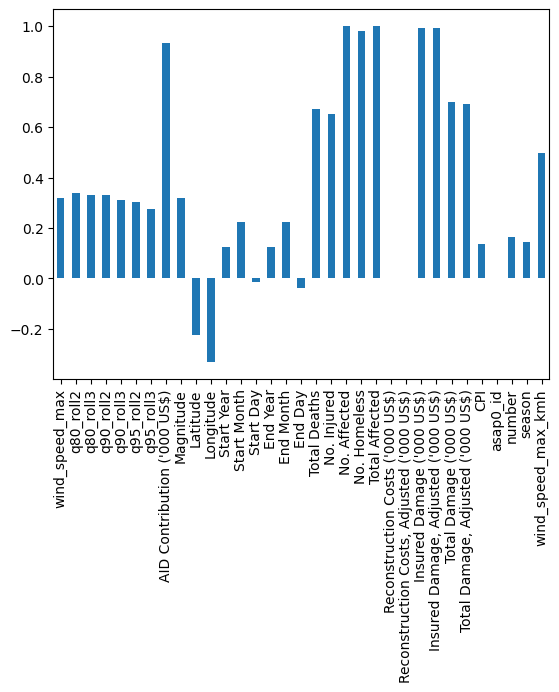

In [52]:
df_stats.corr(numeric_only=True)["Total Affected"].plot.bar()

In [60]:
df_stats_with_impact = df_stats[df_stats["Total Affected"] > 0]

In [61]:
target = "Total Affected"  # your single target column
fixed_col = "wind_speed_max"  # the one you definitely want
other_cols = [
    x for x in df_stats.columns if "roll" in x
]  # the ones you want to test

results = []

for other in other_cols:
    X = df_stats[[fixed_col, other]]
    X = sm.add_constant(X)  # adds intercept term
    y = df_stats[target]

    model = sm.OLS(y, X).fit()
    r2 = model.rsquared

    results.append(
        {
            "other_col": other,
            "r2": r2,
        }
    )

results_df = pd.DataFrame(results).sort_values("r2", ascending=False)
print(results_df)

   other_col        r2
0  q80_roll2  0.208487
1  q80_roll3  0.205793
2  q90_roll2  0.196682
3  q90_roll3  0.187713
4  q95_roll2  0.181907
5  q95_roll3  0.169990


In [66]:
def plot_stats(
    wind_col="wind_speed_max",
    rain_col="q80_roll2",
    impact_col="Total Affected",
):
    df_plot = df_stats_with_impact.copy()
    # cerf_color = "crimson"
    fig, ax = plt.subplots(figsize=(7, 7), dpi=200)

    ymax = df_plot[rain_col].max() * 1.1
    xmax = df_plot[wind_col].max() * 1.1

    bubble_sizes = df_plot[impact_col].fillna(0)
    bubble_sizes_scaled = bubble_sizes / bubble_sizes.max() * 2000

    ax.scatter(
        df_plot[wind_col],
        df_plot[rain_col],
        s=bubble_sizes_scaled,
        # c=df_stats["cerf"].apply(lambda x: cerf_color if x else "k"),
        alpha=0.3,
        edgecolor="none",
        zorder=1,
    )

    for _, row in df_plot.iterrows():
        ax.annotate(
            row["name"].capitalize() + "\n" + str(row["season"]),
            (row[wind_col], row[rain_col]),
            ha="center",
            va="center",
            fontsize=5,
            # color=cerf_color if row["cerf"] == True else "k",
            # zorder=10 if row["cerf"] else 9,
            alpha=0.8,
        )

    ylabel = (
        "Two-day rainfall, 80th percentile over whole country (mm) [IMERG]"
        if rain_col == "q80_roll2"
        else rain_col
    )
    ax.set_ylabel(ylabel)
    ax.set_xlabel(
        "Max. wind speed while within 230 km of Philippines (knots) [IBTrACS]"
    )

    ax.set_xlim(left=0, right=xmax)
    ax.set_ylim(bottom=0, top=ymax)

    ax.set_title("Philippines: historical rainfall and wind speed")

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    return fig, ax

(<Figure size 1400x1400 with 1 Axes>,
 <Axes: title={'center': 'Philippines: historical rainfall and wind speed'}, xlabel='Max. wind speed while within 230 km of Philippines (knots) [IBTrACS]', ylabel='Two-day rainfall, 80th percentile over whole country (mm) [IMERG]'>)

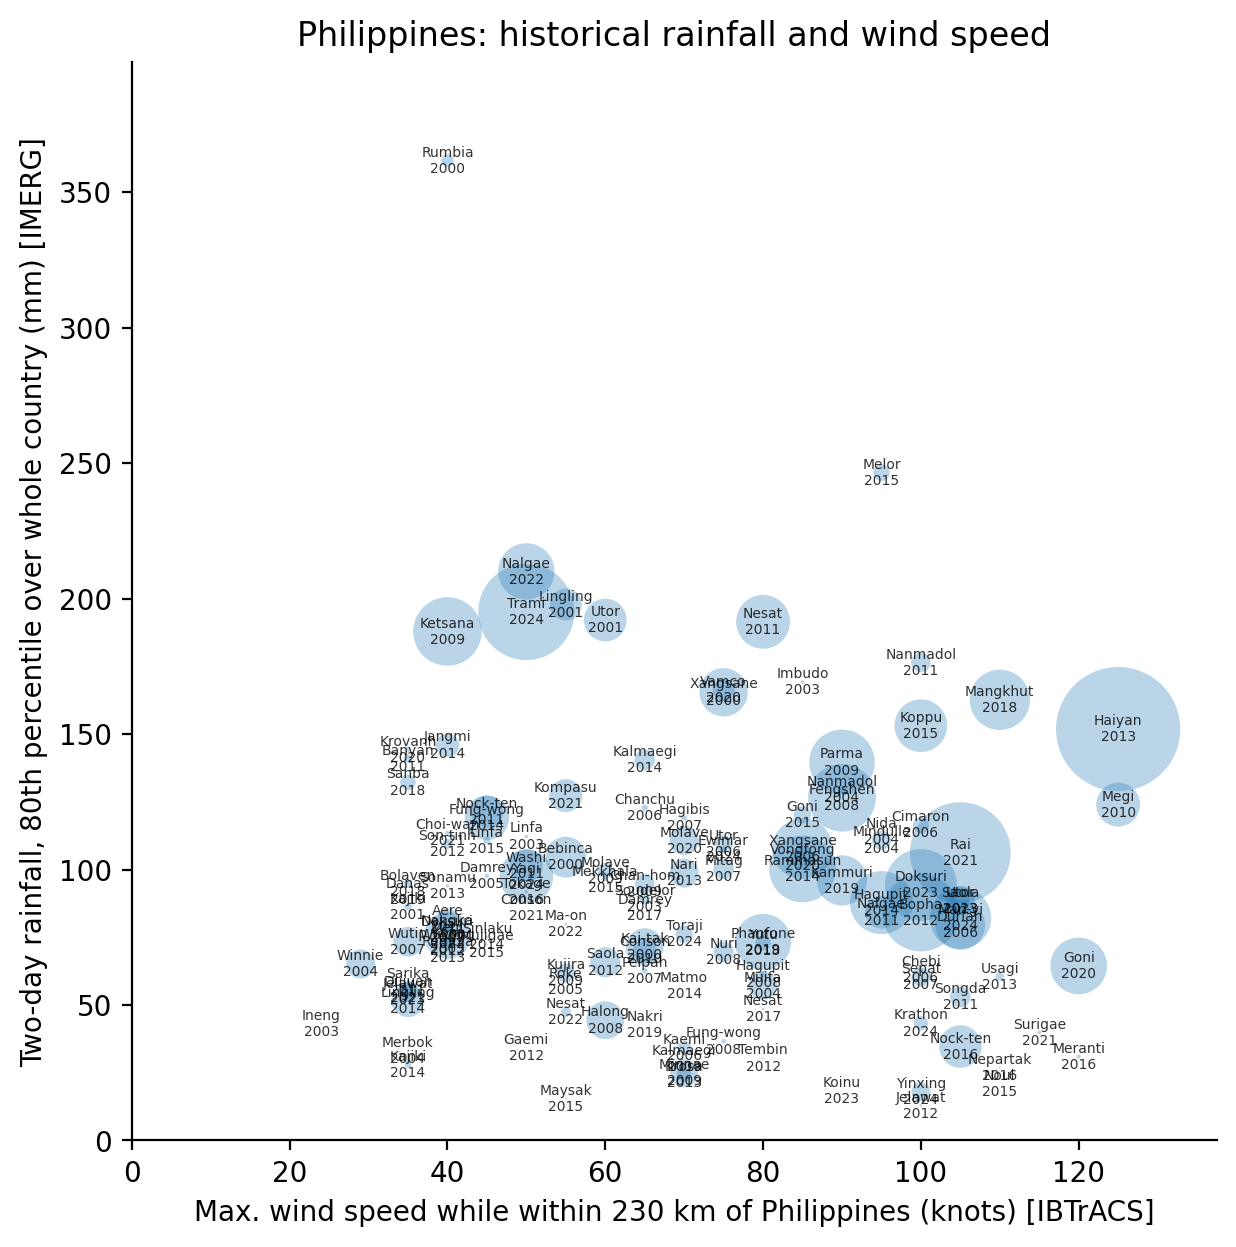

In [67]:
plot_stats()